In [17]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

## Draw plot with error bar (quantum v.s. classical method)

In [2]:
import os, torch
import numpy as np
classical_npy = os.path.join("model", "selfsup", "simclr", "SimCLR-resnet18-quantum_False-classes_600-netwidth_8-nlayers_2-identity_False-epochsize_4800-bsize_128-tepochs_15_0", "training_metrics.npy")
quantum1_npy = os.path.join("model", "selfsup", "simclr", "SimCLR-resnet18-quantum_True-backend_qasm_simulator-classes_600--ansatz_sim_circ_14_half-netwidth_8-nlayers_2-nsweeps_1-activation_null-shots_100-epochsize_4800-bsize_128-tepochs_15_6", "training_metrics.npy")
quantum2_npy = os.path.join("model", "selfsup", "simclr", "SimCLR-resnet18-quantum_True-backend_qasm_simulator-classes_600--ansatz_sim_circ_14_half-netwidth_8-nlayers_2-nsweeps_1-activation_null-shots_100-epochsize_4800-bsize_128-tepochs_15_7", "training_metrics.npy")
quantum3_npy = os.path.join("model", "selfsup", "simclr", "SimCLR-resnet18-quantum_True-backend_qasm_simulator-classes_600--ansatz_sim_circ_14_half-netwidth_8-nlayers_2-nsweeps_1-activation_null-shots_100-epochsize_4800-bsize_128-tepochs_15_8", "training_metrics.npy")
#classical_checkpoint = torch.load(classical_PATH, map_location=torch.device('cpu'))
#quantum_checkpoint = torch.load(quantum_PATH, map_location=torch.device('cpu'))
classical_np = np.load(classical_npy, allow_pickle=True)
quantum1 = np.load(quantum1_npy, allow_pickle=True)
quantum2 = np.load(quantum2_npy, allow_pickle=True)
quantum3 = np.load(quantum3_npy, allow_pickle=True)
#print(checkpoint['acc2'])

In [15]:
quantum_top2_acc = []
classical_top2_acc = []
quantum_top2_acc = quantum_top2_acc + quantum1[1] + quantum2[1] + quantum3[1]
classical_top2_acc = classical_np[1][9:]
print(len(quantum_top2_acc))
print(len(classical_top2_acc))

546
546


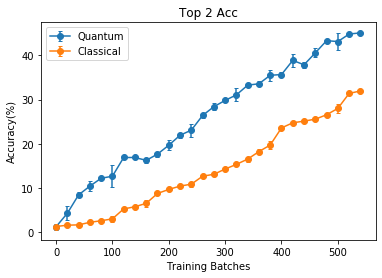

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the following data available:
# quantum_checkpoint = {'acc2': ...}  # Data for the Quantum case
# classical_checkpoint = {'acc2': ...}  # Data for the Classical case

# Compute the standard deviation for every 20 batches
def calculate_std_every_20_batches(data):
    std_values = []
    for i in range(0, len(data), 20):
        batch_subset = data[i:i + 20]
        std_values.append(np.std(batch_subset))
    return std_values

# Calculate standard deviation for every 20 batches
quantum_error = calculate_std_every_20_batches(quantum_top2_acc)
classical_error = calculate_std_every_20_batches(classical_top2_acc)

plt.clf()  # Clear the figure
plt.xlabel('Training Batches')
plt.ylabel('Accuracy(%)')
plt.title("Top 2 Acc")

# Plotting Quantum data with error bars (using standard deviation as error)
plt.errorbar(range(0, len(quantum_top2_acc), 20), quantum_top2_acc[::20], yerr=quantum_error, label="Quantum", fmt='o-', capsize=2)

# Plotting Classical data with error bars (using standard deviation as error)
plt.errorbar(range(0, len(classical_top2_acc), 20), classical_top2_acc[::20], yerr=classical_error, label="Classical", fmt='o-', capsize=2)

plt.legend(loc='upper left')
plt.show()

## Check fingerprint image std and mean

In [19]:
from PIL import Image
import pandas as pd
import os
from scipy.io import loadmat
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
import cv2
import torch
import torchvision.datasets as datasets
import moco.builder
import moco.loader

In [20]:
# 2023-3-12 custom dataset created by Allen LIN

class fingerprintDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.targets = self.img_labels.iloc[:, 1] # label of the dataset
        self.target_transform = target_transform
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[0, 0])
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def __len__(self):
        return len(self.img_labels)

In [44]:
annotations_file = os.path.join("kaggle_fingerprint", "Enhanced_and_cannied", "training_cannied_fingerprint_annotations.csv")
img_dir = os.path.join("kaggle_fingerprint", "Enhanced_and_cannied", "Cannied")
# Normalization for SOCOFing Fingerprint dataset
normalize = transforms.Normalize(mean=[0.1528],
                                     std=[0.1543])
augmentation = [
        transforms.ToPILImage(), # to PIL format
        transforms.RandomResizedCrop(300, scale=(0.2, 1.0)),
#         transforms.RandomApply([
#             transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
#         ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        # transforms.RandomApply([moco.loader.GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        #normalize
]
transform = transforms.Compose(augmentation)
train_dataset = fingerprintDataset(annotations_file, img_dir,
                                   transform=moco.loader.TwoCropsTransform(
                                     transforms.Compose(augmentation)))
imgs, label = train_dataset[0]
print(imgs)
# get the average of standard and mean value of images
avg_std_list = []
avg_mean_list = []
for i in range(10):
    imgs, label = train_dataset[i] # has two images because of augmentation
    print(torch.max(imgs[0]))
    #print(f'img.std: {torch.std(imgs[0])}, img.mean: {torch.mean(imgs[0])}')
    #avg_std_list.append(torch.std(imgs[1]).item())
    #avg_mean_list.append(torch.mean(imgs[1]).item())

#print(f'avg_std_list: {avg_std_list}, avg_mean_list: {avg_mean_list}')
#print(f'means of std_list & mean_list: {np.mean(avg_std_list)}, {np.mean(avg_mean_list)}')

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0471, 0.0235, 0.0039,  ..., 0.0039, 0.0118, 0.0275],
         [0.0392, 0.0157, 0.1333,  ..., 0.0118, 0.0078, 0.0196],
         [0.0000, 0.0000, 0.3098,  ..., 0.0196, 0.0000, 0.0000]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])]
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
